In [ ]:
!pip install wandb -q

In [ ]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ankitt6174 (ankit_6174) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Define your hyperparameters
hyperparameters = {
    "learning_rate": 0.0001,
    "batch_size": 32,
    "embed_dim": 128,
    "num_heads": 4,
    "num_layers": 2,
    "dropout": 0.1,
    "ff_dim": 512,
    "dataset_size": "50K",
    "epochs": 50
}

wandb.init(
    project="dna-mutation-predictor-50K",
    config=hyperparameters,
    name="First Run"
)

In [ ]:
import pandas as pd

data = pd.read_csv(f"{hyperparameters['dataset_size']}.csv")
data.shape

(50000, 2)

In [ ]:
x = data['sequence']
y = data['label']

In [ ]:
def get_codon(seq, k=3):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

vocab = {'<PAD>': 0, '<UNK>': 1}

for seq in data['sequence']:
    for codons in get_codon(seq.lower()):
        if codons not in vocab:
            vocab[codons] = len(vocab)
        else:
            continue

def get_tensor(text):
    return [vocab.get(codons.lower(), vocab['<UNK>']) for codons in get_codon(text)]

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
  def __init__(self, x, y):
    self.x_frame = x
    self.y_frame = y

  def __len__(self):
    return len(self.x_frame)

  def __getitem__(self, index):
    x = torch.tensor(get_tensor(self.x_frame[index]), dtype=torch.long)
    y = torch.tensor(self.y_frame[index], dtype=torch.float32)
    return x, y

In [ ]:
dataset = CustomDataset(x, y)

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'])

In [ ]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp((torch.arange(0, embed_dim, 2)) * (-math.log(10000.0) / embed_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class Transformer(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, num_layers=6, ff_dim=2048, dropout=0.1, vocab_size=10000, max_len=5000):
        super(Transformer, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_encoding = PositionalEncoding(embed_dim=embed_dim, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_layers
        )

        self.y_labels_out = nn.Linear(embed_dim, 5)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.position_encoding(x)

        x = self.encoder(x)
        x = x.mean(dim=1)

        y_label_out = self.y_labels_out(x)
        return y_label_out

In [ ]:
model = Transformer(
    embed_dim=hyperparameters['embed_dim'],
    num_heads=hyperparameters['num_heads'],
    num_layers=hyperparameters['num_layers'],
    ff_dim=hyperparameters['ff_dim'],
    dropout=hyperparameters['dropout'],
    vocab_size=len(vocab),
    max_len=200
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Transformer(
  (embeddings): Embedding(66, 128)
  (position_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (y_labels_out): Linear(in_features=128, out_features=5, bias=True)
)

In [ ]:
device

device(type='cuda')

In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 405637


In [ ]:
ce = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'], weight_decay=1e-4)

In [ ]:
def train(model, loader, ce, optimizer):
    model.train()

    running_loss = 0.0

    for x, y in loader:
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device).long()

        output = model(x)
        loss = ce(output, y)

        loss.backward()

        optimizer.step()

        running_loss += loss.item() * len(x)

    return running_loss / len(loader.dataset)

In [ ]:
def validation(model, loader, ce):
    model.eval()

    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).long()

            output = model(x)

            loss = ce(output, y)

            running_loss += loss.item() * len(x)

            prediction = torch.argmax(output, dim=1)
            correct += (prediction == y).sum().item()

            total += len(x)

    accuracy = correct / total

    return (
        running_loss / len(loader.dataset),
        accuracy
    )

In [ ]:
patience = 10
best_val_loss = float('inf')
counter = 0
early_stop = False

training_loss_arr = []
validation_loss_arr = []
accuracy_arr = []

for epoch in range(hyperparameters['epochs']):
    train_loss = train(
        model,
        train_loader,
        ce,
        optimizer
    )

    val_loss, acc = validation(
        model,
        test_loader,
        ce
    )

    print(f"Epoch ({epoch+1}/{50}): Train Loss = {train_loss:.4f}, Valitation Loss = {val_loss:.4f}, Accuracy = {acc:.4f}")
    training_loss_arr.append(train_loss)
    validation_loss_arr.append(val_loss)
    accuracy_arr.append(acc)

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "accuracy": acc
    })

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        continue
    else:
        counter += 1
        print(f"No improvement in val loss. Counter = {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            early_stop = True
            break

Epoch (1/50): Train Loss = 1.0245, Valitation Loss = 1.0344, Accuracy = 0.5706
Epoch (2/50): Train Loss = 1.0192, Valitation Loss = 1.0357, Accuracy = 0.5706
No improvement in val loss. Counter = 1/10
Epoch (3/50): Train Loss = 1.0141, Valitation Loss = 1.0235, Accuracy = 0.5744
Epoch (4/50): Train Loss = 1.0100, Valitation Loss = 1.0319, Accuracy = 0.5782
No improvement in val loss. Counter = 1/10
Epoch (5/50): Train Loss = 1.0055, Valitation Loss = 1.0142, Accuracy = 0.5793
Epoch (6/50): Train Loss = 0.9980, Valitation Loss = 1.0152, Accuracy = 0.5810
No improvement in val loss. Counter = 1/10
Epoch (7/50): Train Loss = 0.9925, Valitation Loss = 1.0071, Accuracy = 0.5825
Epoch (8/50): Train Loss = 0.9886, Valitation Loss = 1.0073, Accuracy = 0.5838
No improvement in val loss. Counter = 1/10
Epoch (9/50): Train Loss = 0.9845, Valitation Loss = 1.0010, Accuracy = 0.5862
Epoch (10/50): Train Loss = 0.9822, Valitation Loss = 1.0000, Accuracy = 0.5845
Epoch (11/50): Train Loss = 0.9784, V

In [ ]:
from sklearn.metrics import classification_report

def get_predictions_and_labels(model, loader):
    model.eval()
    all_y_true = []

    all_y_pred = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            output = model(x)

            _, prediction = torch.max(output, 1)

            all_y_true.extend(y.cpu().numpy())

            all_y_pred.extend(prediction.cpu().numpy())

    return (all_y_true, all_y_pred)

y_true, y_pred = get_predictions_and_labels(model, test_loader)

print("Classification Report for Label:")
print(classification_report(y_true, y_pred))
print("-"*20)

Classification Report for Label:
              precision    recall  f1-score   support

         0.0       0.21      0.02      0.04       599
         1.0       0.52      0.43      0.47      3203
         2.0       0.65      0.82      0.73      5706
         3.0       0.30      0.12      0.17       229
         4.0       0.29      0.02      0.03       263

    accuracy                           0.61     10000
   macro avg       0.39      0.28      0.29     10000
weighted avg       0.57      0.61      0.57     10000

--------------------


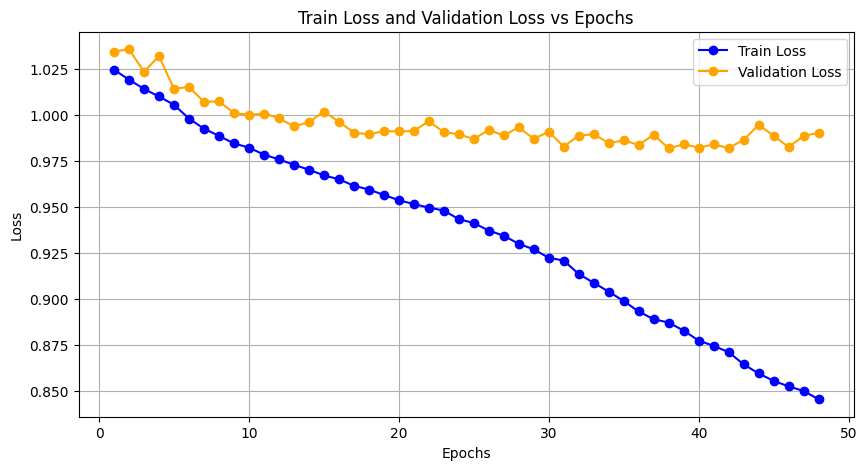

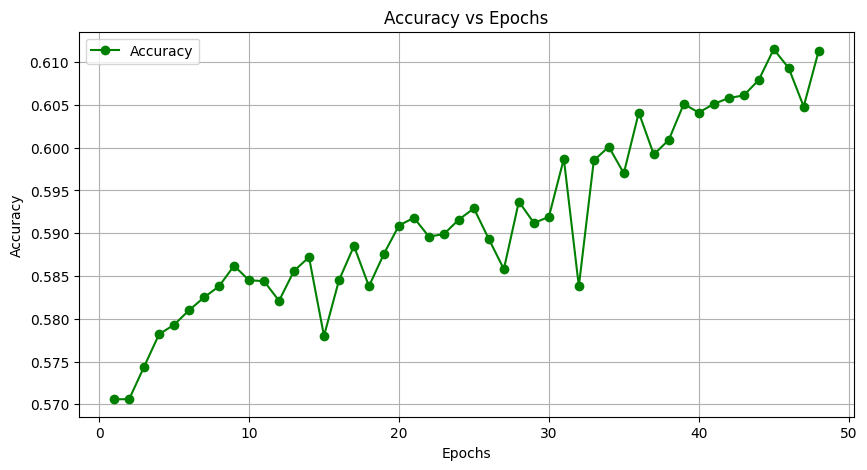

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 49))

training_loss_arr = [
    1.0245, 1.0192, 1.0141, 1.0100, 1.0055, 0.9980, 0.9925, 0.9886, 0.9845, 0.9822,
    0.9784, 0.9758, 0.9729, 0.9702, 0.9671, 0.9650, 0.9615, 0.9594, 0.9565, 0.9536,
    0.9515, 0.9496, 0.9480, 0.9433, 0.9412, 0.9371, 0.9343, 0.9299, 0.9269, 0.9223,
    0.9208, 0.9135, 0.9087, 0.9039, 0.8988, 0.8931, 0.8889, 0.8871, 0.8827, 0.8773,
    0.8744, 0.8710, 0.8644, 0.8594, 0.8554, 0.8524, 0.8499, 0.8454
]

validation_loss_arr = [
    1.0344, 1.0357, 1.0235, 1.0319, 1.0142, 1.0152, 1.0071, 1.0073, 1.0010, 1.0000,
    1.0007, 0.9983, 0.9937, 0.9960, 1.0018, 0.9963, 0.9904, 0.9894, 0.9912, 0.9910,
    0.9913, 0.9965, 0.9907, 0.9894, 0.9869, 0.9918, 0.9888, 0.9932, 0.9870, 0.9908,
    0.9828, 0.9887, 0.9895, 0.9847, 0.9861, 0.9837, 0.9892, 0.9818, 0.9840, 0.9822,
    0.9839, 0.9820, 0.9864, 0.9945, 0.9887, 0.9825, 0.9886, 0.9902
]

accuracy_arr = [
    0.5706, 0.5706, 0.5744, 0.5782, 0.5793, 0.5810, 0.5825, 0.5838, 0.5862, 0.5845,
    0.5844, 0.5821, 0.5856, 0.5872, 0.5780, 0.5845, 0.5885, 0.5838, 0.5876, 0.5909,
    0.5918, 0.5896, 0.5899, 0.5916, 0.5929, 0.5893, 0.5858, 0.5937, 0.5912, 0.5919,
    0.5987, 0.5838, 0.5985, 0.6001, 0.5970, 0.6041, 0.5992, 0.6009, 0.6051, 0.6041,
    0.6051, 0.6058, 0.6061, 0.6079, 0.6115, 0.6093, 0.6048, 0.6113
]


plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss_arr, label='Train Loss', marker='o', color='blue')
plt.plot(epochs, validation_loss_arr, label='Validation Loss', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss and Validation Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_arr, label='Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()